# Transformer Encoder for Energy Reconstruction in Telescope Array Experiment

This notebook demonstrates how to build a transformer-based neural network for analyzing cosmic ray data from the Telescope Array experiment. 
The model processes data from activated detectors for each cosmic-ray-induced event and predicts the energy of the primary particle.

# 1. Import required libraries

We will use:

- PyTorch: For creating and training neural networks
- NumPy: For numerical operations and data handling
- h5py: For reading HDF5 files containing our experimental data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader

import numpy as np
import h5py as h5
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# 2. Data Generation and Preprocessing

In the Telescope Array experiment, cosmic ray events are detected by an array of surface detectors spread across a large area.
We will use data that was passed thorough the reconstruction procedure and passes both *composition* and *spectrum* cuts. 

Full information on an event is given by a set of all triggered detectors.  
Each detector is characterized by 5 features:
- Its x, y, z coordinates (spatial position)
- Integral registered charge (energy deposited)
- Time of the plane from arrival (obtained from the reconstruction procedure)
- Difference in time between plane front arrival and and actual activation (helps analyze wavefront curvature)

The number of activated detectors varies from event to event. 
To pass them through NN, one should cast them to a unform "length" in the following way:
- For each batch, we find the maximum number of triggered detectors (`max_event_length`)
- Events with fewer detectors are padded with "auxiliary detectors" (zeros)
- We add a mask channel (value 1 for real detectors, 0 for padding) to allow the network to distinguish real data from padding

This results in input tensors with shape (batch_size, max_event_length, 7) where the last dimension includes the 6 detector features plus the mask. The neural network will be designed to ignore these auxiliary detectors.

Our neural network will predict the logarithm (base 10) of the primary particle energy. The ground truth values are extracted from the simulation data.

## Some technical remarks

Datsets has an option to augment data with noise. This allows to avoid overfitting and make NNs prediction more robust.

For convenience, the train dataset is made infinite via self-looping.

Detectors data is stored in a two dimensional array `dt_params` with shape `(total_detectors, 5)`, where `total_detectors` is the total number of detectors activated in all events (all detectors data is concatenated in a single array).
External indexing array `ev_starts` is used to extract data for a required event: for i-th events, the corresponding data is `data_i = dt_params[start:stop]`, where `start=ev_starts[i]` and `start=ev_starts[i+1]`.
In particular, event length array can be obtained as `np.diff(ev_starts)`.

In [2]:
# Default padding values for sequences shorter than the maximum length
dense_def_vals = torch.tensor([[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]], dtype=torch.float32)

class DatasetGenerator(IterableDataset):
    """
    Generates batches of detector data from HDF5 files for training and testing.
    
    - Handles variable-length sequences via padding
    - Supports data augmentation with Gaussian noise (additive and multiplicative)
    - Creates an infinite dataset for training via self-loop
    - Properly initializes workes so each of them reads its own part of data
    """
    def __init__(self, file, regime, batch_size, return_reminder,
                 apply_add_gauss, gauss_stds,
                 apply_mult_gauss, mult_gauss_std
                 ):
        """
        Initialize the dataset generator.
        
        Parameters:
        - file: Path to the HDF5 file containing the training data
        - regime: 'train' or 'test' mode
        - batch_size: Number of events per batch
        - return_reminder: Whether to return the last incomplete batch
        - apply_add_gauss: Apply additive Gaussian noise for data augmentation
        - gauss_stds: Standard deviations for the additive noise in physical units
        - apply_mult_gauss: Apply multiplicative Gaussian noise
        - mult_gauss_std: Standard deviation for multiplicative noise
        """
        self.file = file
        self.regime = regime
        self.batch_size = batch_size
        self.apply_add_gauss = apply_add_gauss
        self.apply_mult_gauss = apply_mult_gauss
        self.g_mult_stds = mult_gauss_std

        # Get normalization parameters and dataset size from the HDF5 file
        with h5.File(self.file,'r') as hf:
            mean = hf['norm_param/dt_params/mean'][3]
            std = hf['norm_param/dt_params/std'][3]
            self.num = hf[self.regime+'/ev_starts'].shape[0]-1
        
        # Configure noise parameters
        if apply_add_gauss:
            self.guass_add_stds = gauss_stds / std
        if apply_mult_gauss:
            self.Q_mean_noise = mean / std
            self.n_fraction = mult_gauss_std

        # Determine the stop index (end of dataset or last complete batch)
        batch_num = self.num // self.batch_size
        self.stop = self.num if return_reminder else self.batch_size * batch_num

    # Add Gaussian noise to the data for augmentation.
    def add_gauss(self, data, std):
        noise = np.random.normal(scale=self.guass_add_stds, size=data.shape)
        data += noise
        return data

    # Apply multiplicative Gaussian noise to charge values.
    def mult_gauss(self, Qs):
        noises = np.random.normal(scale=self.n_fraction, size=Qs.shape)
        return Qs + noises * (Qs + self.Q_mean_noise)

    # 
    def step(self, hf, start_ev, stop_ev, start_det, stop_det):
        """
        Process a batch of events from the HDF5 file.
        - start_ev, stop_ev: Start and stop indices for events
        - start_det, stop_det: Start and stop indices for detectors

        Returns:
        - dt_params: Detector parameters for events (as 2D array)
        - energy_labels: True energy values (log10 scale)
        """
        # Read detector parameters for events
        dt_params = hf[self.regime+'/dt_params'][start_det:stop_det]
        # Extract energy labels (log10 of primary particle energy)
        energy_labels = np.log10(hf[self.regime+'/mc_params/'][start_ev:stop_ev,3:4])
        # Apply data augmentation if enabled
        if self.apply_add_gauss:
            dt_params = self.add_gauss(dt_params, self.guass_add_stds)
        if self.apply_mult_gauss:
            dt_params[...,3] = self.mult_gauss(dt_params[...,3])
        
        return dt_params, energy_labels

    def __iter__(self):
        """
        An iterator that yields batches of data.
    
        For training data, this creates an infinite dataset via self-loop.
        For test data, this iterates once through the dataset.
        
        Yields:
        - padded: Padded detector data with mask [batch_size, max_seq_len, 7]
        - labels: Energy labels [batch_size, 1]
        """
        
        # Initialize multiple workers
        # Get worker information
        worker_info = torch.utils.data.get_worker_info()
        # Determine the range of data this worker should process
        if worker_info is None:  # single-process data loading
            worker_start = 0
            worker_end = self.stop
        else:  # in a worker process
            # Split workload 
            per_worker = int(np.ceil(self.stop / float(worker_info.num_workers)))
            worker_id = worker_info.id
            
            worker_start = worker_id * per_worker
            worker_end = min(worker_start + per_worker, self.stop)
            
            # Adjust to batch boundaries
            worker_start = (worker_start // self.batch_size) * self.batch_size
            worker_end = min(((worker_end + self.batch_size - 1) // self.batch_size) * self.batch_size, self.stop)
        
        # Open the HDF5 file within __iter__ so that each worker gets its own handle.
        with h5.File(self.file, 'r') as hf:
            start_ev = worker_start
            
            iterate = True
            while iterate:
                stop_ev = start_ev + self.batch_size
                
                # Check if we've reached the end of this worker's range
                if stop_ev > worker_end:
                    # For training, make infinite dataset by resetting to start
                    if self.regime == 'train':
                        # Reset back to the start of this worker's range
                        start_ev = worker_start
                        stop_ev = start_ev + self.batch_size
                    else:
                        iterate = False
                
                # Read detector indices for events
                ev_idxs = hf[self.regime+'/ev_starts'][start_ev:stop_ev+1]
                # Get detector parameters and energy labels
                dt_params, labels = self.step(hf, start_ev, stop_ev, ev_idxs[0], ev_idxs[-1] )

                # Make regular tensors
                # Calculate the number of detectors per event
                raw_lens = np.diff(ev_idxs).astype(np.int64)
                max_len = raw_lens.max() # Maximum sequence length in this batch

                # Convert the actual data to torch tensors.
                data = torch.from_numpy(dt_params)      # shape: (total_dets, 6)
                labels = torch.from_numpy(labels)       # shape: (total_evs, 1)
                
                # Create mask: 1 for real detectors, 0 for padding
                mask = torch.ones((data.shape[0], 1), dtype=torch.float32) # shape: (total_dets, 1)
                # Concatenate detector features and mask
                data = torch.cat([data, mask], dim=-1)
                
                # Preallocate padded tensor: shape (batch_size, max_len, 7), filled with default values.
                padded = torch.tile(dense_def_vals, (labels.shape[0], max_len, 1))
                
                # Create a boolean mask with shape (batch_size, max_len).
                # For each event, positions [0, raw_lens[i]) are True.
                mask = np.arange(max_len)[None, :] < raw_lens[:, None]  # shape: (batch_size, max_len)
                mask_tensor = torch.from_numpy(mask)
                
                # Fill the padded tensor with actual data
                padded[mask_tensor] = data

                # Move to next batch
                start_ev += self.batch_size

                yield padded.float(), labels.float() # also convert to float32

def make_datasets(file, batch_size,
                 apply_add_gauss, gauss_stds,
                 apply_mult_gauss, mult_gauss_std):
    """
    Create train and test datasets.
    
    Parameters:
    - file: Path to the HDF5 file
    - batch_size: Number of events per batch
    - apply_add_gauss: Whether to apply additive Gaussian noise (for augmentation)
    - gauss_stds: Standard deviations for additive noise
    - apply_mult_gauss: Whether to apply multiplicative Gaussian noise
    - mult_gauss_std: Standard deviation for multiplicative noise
    
    Returns:
    - train_dataset: DataLoader for training
    - test_dataset: DataLoader for testing
    """
    # Create generators for train and test datasets
    train_generator = DatasetGenerator(file, 'train', batch_size, False,
                 apply_add_gauss, gauss_stds,
                 apply_mult_gauss, mult_gauss_std)
    test_generator = DatasetGenerator(file, 'test', batch_size, False,
                 False, None,
                 False, None)

    # Create DataLoader objects
    train_dataset = DataLoader(train_generator, batch_size=None, shuffle=False, pin_memory=True, num_workers=0, prefetch_factor=None)
    test_dataset = DataLoader(test_generator, batch_size=None, shuffle=False, pin_memory=True, num_workers=0, prefetch_factor=None)

    return train_dataset, test_dataset

## Take a look at data

Below we initiate dataset generator and take a look at one batch.
Each event is padded to the maximal "length" in the batch and auxiliary detectors are added.

In [3]:
generator_config = {
  'file' : '', # Set your path to the training file
  'batch_size' : 4, # batch size
  'apply_add_gauss' : False, # flag for addative data augmentation
  'gauss_stds' : [0., 0., 0., 0., 0. , 0.], # noise parameters
  'apply_mult_gauss' : False, # flag for multiplicative augmentation of registered charges
  'mult_gauss_std' : 0.0 # noise parameters
}

train_generator = DatasetGenerator(regime='train', return_reminder=False, **generator_config)

for data, label in train_generator.__iter__():
    break

In [4]:
print(data.shape, label.shape)
print(data[:2])

torch.Size([4, 34, 7]) torch.Size([4, 1])
tensor([[[ 0.5414, -1.5941, -1.2051, -0.4940, -0.5042, -0.3481,  1.0000],
         [ 0.5461, -0.8243, -1.1074, -0.4972, -0.2328, -0.7657,  1.0000],
         [-0.1986, -0.7951, -1.0037, -0.4665, -0.0465, -0.6553,  1.0000],
         [ 0.5435, -0.0488, -1.0852,  0.0252,  0.0443, -0.8896,  1.0000],
         [ 0.5435, -0.0488, -1.0852,  0.0252,  0.0443,  0.3297,  1.0000],
         [ 0.5442,  0.7246, -0.9282, -0.4936,  0.3160, -0.7222,  1.0000],
         [-0.9999, -0.0454, -1.0370, -0.4302,  0.4144, -0.9027,  1.0000],
         [-0.2268,  0.7237, -0.8708, -0.3854,  0.4993, -0.7661,  1.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.000

# 3. Metrics

When training neural networks, we need metrics to track performance. 
Here we implement a simple metric that tracks the average value of the loss function.

In [5]:
class MeanMetrics(nn.Module):

    # Initialize metric
    def __init__(self, name):
        super().__init__()
        self.register_buffer('value', torch.tensor(0.0))
        self.register_buffer('steps', torch.tensor(0.0))
        self.name = name

    # Define how to reset metric
    def reset(self):
        self.value.zero_()
        self.steps.zero_()

    # Define how to update state
    def update_state(self, value):
        self.value.add_(value.detach())
        self.steps.add_(1.)

    # Define the resulting metric value
    def result(self):
        return self.value / (self.steps + 1e-9) # Add small epsilon to avoid division by zero

# 4. Neural netowrk architecture

Now we'll implement a transformer-based architecture for analyzing detector data. Transformers use self-attention mechanisms to weigh the importance of different detectors for updating nodes (detectors features) and making predictions.

We will use several encoder layers to process data and then aggragate it to infer the energy of the primary particle.

## 4.1 Attention mechanism

The core of a transformer architecture.
It defines how each detector to "looks at" all other detectors in the event and gather information from those that are most relevant. 
For example:

- A detector near the core of the shower might need to pay attention to distant detectors to understand the overall shower geometry
- Detectors with unusual timing might need to be contextualized by the overall pattern
- Some detectors might contain noise and should be downweighted

The attention mechanism learns which detectors should "pay attention" to which other detectors to best reconstruct the energy of the primary particle.

### 4.1.1 Query, Key, Value Projections

**What are Query, Key, and Value?**

The Query, Key, and Value (QKV) concepts come from information retrieval systems:

*Query (Q)*: Represents "what information am I looking for?" For each detector, its Query representation encodes what kind of information it needs from other detectors.

*Key (K)*: Represents "what information do I contain?" For each detector, its Key representation encodes what kind of information it can provide to other detectors.

*Value (V)*: Represents "what is my actual content?" For each detector, its Value representation encodes the information it will contribute if deemed relevant.

Query, Key, and Value are usually linear projections from nodes (detector) features. 
Such dimensin reduction is efficient and allows to control the required memory size.

In general, Query, Key, and Value can be obtained from different sources (sequences).
In our case, the source is the same - detectors data.
Such attention mechanism is dubbed **self-attention**.

In [6]:
# general implementation
class QKVProjector(nn.Module):

    def __init__(self, query_dim, key_dim, value_dim, att_dim):
        """
        - query_dim, key_dim, value_dim: Dimension of query, key, values
        - att_dim: Dimension for attention features
        """
        super().__init__()
        self.q_proj = nn.Linear(query_dim, att_dim, bias=True)
        self.k_proj = nn.Linear(key_dim, att_dim, bias=True)
        self.v_proj = nn.Linear(value_dim, att_dim, bias=True)
        
        # Initialize weights
        nn.init.xavier_normal_(self.q_proj.weight)
        nn.init.zeros_(self.q_proj.bias)
        nn.init.xavier_normal_(self.k_proj.weight)
        nn.init.zeros_(self.k_proj.bias)
        nn.init.xavier_normal_(self.v_proj.weight)
        nn.init.zeros_(self.v_proj.bias)

    def forward(self, q_soure, k_source, v_source):
        """
        Project input features to Q, K, V space.
        
        Parameters:
        - query_soure: Input tensor [batch_size, seq_len, query_dim]
        - key_soure: Input tensor [batch_size, seq_len, key_dim]
        - value_soure: Input tensor [batch_size, seq_len, value_dim]
        
        Returns:
        - q, k, v: Query, Key, Value projections [batch_size, seq_len, att_dim]
        """
        qs = self.q_proj()
        ks = self.k_proj()
        vs = self.v_proj()
        return qs, ks, vs

In [7]:
# self-attenttion impementation
class QKVProjector(nn.Module):

    def __init__(self, input_dim, att_dim):
        """
        - input_dim: Dimension of input features
        - att_dim: Dimension for attention features
        """
        super().__init__()
        # Single layer for self attention
        self.qkv_proj = nn.Linear(input_dim, 3 * att_dim, bias=True)
        # Initialize weights
        nn.init.xavier_normal_(self.qkv_proj.weight)
        nn.init.zeros_(self.qkv_proj.bias)

    def forward(self, x):
        """
        Project input features to Q, K, V space.
        
        Parameters:
        - x: Input tensor [batch_size, seq_len, input_dim]
        
        Returns:
        - q, k, v: Query, Key, Value projections [batch_size, seq_len, att_dim]
        """
        qkv = self.qkv_proj(x)
        # Split into Q, K, V
        return qkv.chunk(3, dim=-1)

### Test the layer

In [ ]:
qkv_proj = QKVProjector(input_dim=7, att_dim=5)
with torch.no_grad():
    qs, ks, vs = qkv_proj(data)
print(qs.shape, ks.shape, vs.shape)

### 4.1.2 Attention Layer

Once we have the Q, K, and V representations, the attention layer computes how much each detector should attend to every other detector.

The Attention Calculation Process:

- Compatibility Scores: We compute the dot product between each Query and all Keys. If a detector's Query is similar to another detector's Key, they'll have a high compatibility score, meaning the first detector should pay attention to the second.
- Scaling: We divide by √(head_dim) to prevent the dot products from growing too large, which would push the softmax into regions with very small gradients.
- Masking: We apply a mask to zero out attention to padding elements (auxiliary detectors). We set their scores to a large negative value (-1e9) so that after softmax, they'll have practically zero weight.
- Softmax Normalization: We apply softmax to convert the scores into a probability distribution (all positive, summing to 1).
- Weighted Sum: We use these attention weights to compute a weighted sum of the Value vectors. This gives each detector a new representation that incorporates information from other relevant detectors.

### Mask Shape and Creation

The mask must cover the entire attention matrix, which has shape [batch_size, num_heads, seq_len, seq_len]. 
Each position (i,j) in this matrix represents the attention score from detector i to detector j.

We will create proper mask later as it can be reused by all attention layers.

In [8]:
class AttentionLayer(nn.Module):

    def __init__(self, head_dim):
        """
        - head_dim: Dimension of each attention head
        """
        super().__init__()
        # Scaling factor for dot product attention (improves gradient stability)
        scaling_factor = torch.sqrt(torch.tensor([head_dim], dtype=torch.float))
        self.register_buffer('scaling_factor', scaling_factor)

    def forward(self, qs, ks, vs, mask):
        """
        Calculate attention scores and weighted values.
        
        Parameters:
        - qs: Query tensor [batch_size, num_heads, seq_len, head_dim]
        - ks: Key tensor [batch_size, num_heads, seq_len, head_dim]
        - vs: Value tensor [batch_size, num_heads, seq_len, head_dim]
        - mask: Attention mask to ignore padding [batch_size, 1, seq_len, seq_len]
        
        Returns:
        - Weighted sum of values based on attention scores
        """
        # Calculate dot product attention scores
        # (Q·K^T)/sqrt(d_k)
        attention_logits = torch.matmul(qs, ks.transpose(-2, -1)) / self.scaling_factor
         # Mask out padding by setting attention logits to large negative value
        # This ensures softmax will give ~0 probability to padding
        attention_logits = attention_logits.masked_fill(mask == 0, -1e9)
        # Apply softmax to get attention weights
        attention_weights = torch.softmax(attention_logits, dim=-1)
         # Zero out weights for padding (additional safety)
        attention_weights = attention_weights * mask
         # Compute weighted sum of values
        return torch.matmul(attention_weights, vs)

### Test the layer

In [ ]:
att_layer = AttentionLayer(3)
mask = data[:,:,-1:]
with torch.no_grad():
    scores = att_layer(qs, ks, vs, mask)
print(scores.shape)

### 4.1.3 Multi-Head Attention
Multi-head attention extends the basic attention mechanism by allowing the model to jointly attend to information from different representation subspaces

Why Multiple Heads?

Think of multi-head attention as having multiple "perspectives" or "viewpoints" from which to analyze the relationships between detectors:

- Different Relationship Types: Some heads might focus on spatial relationships, others on timing patterns, others on energy deposition correlations.
- Complementary Information: Each head can capture different aspects of the detector relationships, and together they provide a more comprehensive understanding.
- Parallel Processing: Multiple heads process information in parallel, allowing the model to capture multiple types of dependencies simultaneously.

How Multi-Head Attention Works:

- Projection: We project the input into Q, K, V representations that contain information for all heads concatenated.
- Reshaping: We reshape these projections to separate the different heads.
- Attention per Head: We apply the attention mechanism separately for each head.
- Concatenation: We reshape and concatenate the outputs from all heads.
- Final Projection: We project the concatenated output back to the model dimension.

In [9]:
# Implement multi head attention
class MultiheadAttention(nn.Module):
    
    def __init__(self, in_features, num_heads, head_dim, out_features, dropout):
        """
        - in_features: Input feature dimension
        - num_heads: Number of attention heads
        - head_dim: Dimension of each head
        - out_features: Output feature dimension
        - dropout: Dropout rate for regularization
        """
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim
        # Projection for Query, Key, Value
        self.proj_layer = QKVProjector(in_features, num_heads * head_dim)
        # Attention calculation layer
        self.att_layer = AttentionLayer(head_dim)
        # Final projection to output dimension
        self.proj_out = nn.Linear(num_heads * head_dim, out_features, bias=True)
        # Optional dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # Initialize output projection
        nn.init.xavier_normal_(self.proj_out.weight)
        nn.init.zeros_(self.proj_out.bias)

    def forward(self, x, mask_att):
        """
         Parametrs:
        - x: Input tensor [batch_size, seq_len, in_features]
        - mask_att: Attention mask [batch_size, 1, seq_len, seq_len]
        
        Returns:
        - Output tensor [batch_size, seq_len, out_features]
        """
        batch_size, seq_len, _ = x.size()
        # Get query, key, value projections for all heads
        qs, ks, vs = self.proj_layer(x) # shape [batch, seq_len, num_heads * head_dim]
        # Reshape to separate the heads
        # [batch_size, seq_len, num_heads*head_dim] -> [batch_size, num_heads, seq_len, head_dim]
        qs = qs.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        ks = ks.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        vs = vs.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        # Apply attention mechanism
        msgs = self.att_layer(qs, ks, vs, mask_att) # shape [batch, num_heads, seq_len, head_dim]
        # Reshape back: [batch_size, seq_len, num_heads*head_dim]
        # [batch, num_heads, seq_len, head_dim] -> [batch, seq_len, num_heads * head_dim]
        msgs = msgs.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        # Final projection and dropout
        return self.dropout(self.proj_out(msgs))

### Test the layer

In [ ]:
mha_layer = MultiheadAttention(in_features=7, num_heads=2, head_dim=5, out_features=4, dropout=0.)
mask_att = (mask * torch.transpose(mask, 1, 2)).unsqueeze(1)
with torch.no_grad():
    scores = mha_layer(data, mask_att)
print(scores.shape)

## 4.2 Feed forward layer 

The Feed-Forward Network (FFN) follows the attention mechanism. 
While attention allows detectors to exchange information with each other, the FFN processes this information independently for each detector position.

**Theoretical Background**

In transformer architectures, the Feed-Forward Network serves several important purposes:

- Feature Transformation: It applies non-linear transformations to the attention outputs, enabling the model to learn complex patterns
- Position-wise Processing: Each detector's representation is processed independently, allowing the model to extract node-specific features
- Capacity Enhancement: By expanding to a higher dimension and then projecting back, it increases the model's representational capacity

In [10]:
class FeedForward(nn.Module):

    def __init__(self, d_ff, d_model, dropout=0.):
        """
        Initialize the feed-forward network.
        
        Parameters:
        - d_ff: Hidden layer dimension (typically 4x d_model for transformers)
        - d_model: Model dimension (input and output)
        - dropout: Dropout rate for regularization
        """
        super().__init__()
        # First linear transformation (expansion)
        self.linear1 = nn.Linear(d_model, d_ff)
        # Second linear transformation (projection)
        self.linear2 = nn.Linear(d_ff, d_model)
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.xavier_normal_(self.linear2.weight)
        nn.init.zeros_(self.linear1.bias)
        nn.init.zeros_(self.linear2.bias)

    def forward(self, x):
        # The process follows: expand -> activate -> dropout -> project
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))

### Test the layer

In [ ]:
ff_layer = FeedForward(14, 7, dropout=0.)
with torch.no_grad():
    updated = ff_layer(data)
print(updated.shape)

## 4.3 Encoder Layer

The Encoder Layer is the fundamental building block of the transformer architecture. 
It processes detector information through two main sub-layers: a multi-head self-attention mechanism and a position-wise feed-forward network. 
Multiple encoder layers are stacked to form the complete transformer encoder.

**Theoretical Background**

Each encoder layer performs the following operations:

- Self-Attention: Allows each detector to attend to all other detectors, capturing relationships regardless of their spatial positions
- Residual Connection + Layer Normalization: Helps with gradient flow and training stability
- Feed-Forward Network: Processes each detector's representation independently
- Second Residual Connection + Layer Normalization: Further improves training dynamics

The residual connections (also called "skip connections") are crucial as they allow gradients to flow directly through the network during backpropagation, mitigating the vanishing gradient problem in deep networks.

**The mathematical formulation for an encoder layer is:**

AttentionBlock: z = LayerNorm(x + Dropout(MultiHeadAttention(x)))

FFNBlock: output = LayerNorm(z + Dropout(FFN(z)))

Each node (detector) are processed in parallel. 
Masking is applied to ignore padding detectors.

In [11]:
# Single encoder layer
class EncoderLayer(nn.Module):
    """
    Single transformer encoder layer.
    
    Each encoder layer consists of:
    1. Multi-head self-attention mechanism
    2. Residual connection and layer normalization
    3. Position-wise feed-forward network
    4. Second residual connection and layer normalization
    """
    def __init__(self, num_heads, d_model, d_ff, att_dim, dropout):
        """
        Parameters:
        - num_heads: Number of attention heads (each focusing on different aspects)
        - d_model: Model dimension (size of detector representations)
        - d_ff: Feed-forward hidden dimension (typically 4x d_model)
        - att_dim: Attention head dimension (d_model / num_heads)
        - dropout: Dropout rate for regularization
        """
        super().__init__()
        # Multi-head attention for processing detector relationships
        # This allows detectors to exchange information based on relevance
        self.mha = MultiheadAttention(
            in_features=d_model,
            num_heads=num_heads,
            head_dim=att_dim,
            out_features=d_model,
            dropout=dropout
        )
        # Position-wise feed-forward network
        # Processes each detector's features independently
        self.ffn = FeedForward(d_ff, d_model, dropout)
        # Layer normalization for training stability
        # Applied after each residual connection
        # Normalizes each detector's features to have zero mean and unit variance
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout for regularization
        # Applied to attention outputs and FFN outputs before residual connections
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask, mask_att):
        """
        Parameters:
        - x: Input tensor [batch_size, seq_len, d_model]
          Each element in seq_len represents a detector's features
        - mask: mask for auxiliary detectors [batch_size, seq_len, 1]
          Binary mask marking real (1) vs. padding (0) detectors
        - mask_att: Attention mask [batch_size, 1, seq_len, seq_len]
          Controls which detector pairs can attend to each other
        
        Returns:
        - Output tensor [batch_size, seq_len, d_model]
          Updated detector representations after attention and FFN
        """
        # 1. Self-attention block
        # Each detector gathers information from other relevant detectors
        attn_output = self.mha(x, mask_att)
        # 2. First residual connection and layer normalization
        # Residual: Add the original input to preserve information
        # LayerNorm: Normalize for stability
        out1 = self.norm1(x + self.dropout(attn_output))
        # 3. Feed-forward block with mask applied
        # Process each detector independently and mask out padding detectors
        ff_output = self.ffn(out1) * mask
        # 4. Second residual connection and layer normalization.
        # Apply mask to ensure padding detectors remain at zero
        out2 = self.norm2(out1 + self.dropout(ff_output)) * mask
        return out2

### Test the layer

In [ ]:
encoder_layer = EncoderLayer(num_heads=2, d_model=7, d_ff=14, att_dim=5, dropout=0.)
with torch.no_grad():
    updated_data = encoder_layer(data, mask, mask_att)
print(updated_data.shape)

## 4.4 Aggregation Layer

To infer energy of the primary particle, we need to aggregate data from all detectors. 
We will use averaging for this purpose. 

Another approach is to introduce classifiaction token.
We will not use this advanced technique.

In [12]:
class AggregateLayer(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x, mask):
        """ 
        Return average taking into account mask
        Parameters:
        - x: data tensor [batch_size, seq_len, d_model]
        - mask: mask for auxiliary detectors [batch_size, 1]
        """
        return torch.sum(x*mask, dim=1) / torch.sum(mask, dim=1)

### Test the layer

In [ ]:
aggr_layer = AggregateLayer()
with torch.no_grad():
    aggregated = aggr_layer(updated_data, mask)
print(aggregated.shape)

## 4.5 Prediction Layer

The Prediction Layer is the final component of our network that takes the aggregated detector information and transforms it into the energy prediction.
After the transformer encoder processes and contextualizes all detector activations, we need a way to combine this information and map it to our target variable: the log10 of the primary particle's energy.

In [13]:
class PredictLayer(nn.Module):
    """
    Final prediction layer that processes aggregated detector data.
    
    This layer implements a multi-layer perceptron (MLP) that maps from
    the transformer's high-dimensional representation space to the 
    energy prediction (log10 scale). It consists of:
    
    1. A reduction layer that maps from the model dimension to a smaller dimension
    2. Optional intermediate layers for additional capacity
    3. A final output layer that produces the energy prediction
    
    Each layer is followed by a Leaky ReLU activation, except the final output
    which produces a raw scalar value.
    """

    def __init__(self, dim_in, dim_middle, dim_out, num_middle_layers):
        """
        - dim_in: Input dimension (from transformer encoder, typically d_model)
        - dim_middle: Hidden layer dimension (smaller than dim_in for efficiency)
        - dim_out: Output dimension (1 for energy prediction)
        - num_middle_layers: Number of hidden layers between reduction and output
        """
        super().__init__()
        # Initial dimension reduction
        # This compresses the high-dimensional detector representation
        # to a more manageable size for the regression task
        self.reduce = nn.Linear(dim_in, dim_middle)
        # Hidden layers for additional modeling capacity
        # Each layer maintains the same dimension (dim_middle)
        self.pre_layers = nn.ModuleList([
            nn.Linear(dim_middle, dim_middle) for _ in range(num_middle_layers)
        ])
        # Final output layer that produces the energy prediction
        # Maps from the hidden dimension to a single scalar output
        self.out = nn.Linear(dim_middle, dim_out)
        # Leaky ReLU activation function
        self.activation = F.leaky_relu

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor [batch_size, dim_in]
          This contains aggregated information from all detectors for each event
        
        Returns:
        - Predictions [batch_size, dim_out]
          Log10 of the predicted energy for each event
        """
        # Initial dimension reduction with activation
        x = self.reduce(x)
        x = self.activation(x)
        # Apply each hidden layer with activation
        for layer in self.pre_layers:
            x = layer(x)
            x = self.activation(x)
        # Final prediction layer (no activation)
        return self.out(x)

### Test the layer

In [ ]:
pred_layer = PredictLayer(dim_in=7, dim_middle=2, dim_out=1, num_middle_layers=2)
with torch.no_grad():
    preds = pred_layer(aggregated)
print(preds.shape)

## 4.6 Embedding layer

Our initial data has 6 features, while transformer has higher dimensionality.
We need to embed your data to this higher dimensional space.

This can be done via a single linear layer.
To preserve physical data, we initialize it as identity matrix and allow NN to optimize it.

### On positional encoding

Position encoding is needed when node encodings do not provide positional information (for example, tokens in natural language processing).
In our case, nodes (detectors) has both temporal and spatial information, which yield positional encoding redundant.

In [14]:
class EmbeddingLayer(nn.Module):

    def __init__(self, dim_in, dim_out):
        """
        - dim_in: Input dimension (number of detector features)
        - dim_out: Hidden layer dimension (transformer dimensionality)
        """
        super().__init__()
        self.dense = nn.Linear(dim_in, dim_out, bias=False)
        # Initialize matrix as identity
        nn.init.eye_(self.dense.weight)

    def forward(self, x):
        # Linearly map to transformer dimensionality 
        return self.dense(x)

### Test the layer

In [ ]:
emb_layer = EmbeddingLayer(dim_in=7, dim_out=24)
with torch.no_grad():
    embd = emb_layer(data)
print(embd.shape)

## 4.7 Complete Encoder Model

The Encoder class brings together all the components we've built to create a complete transformer-based model for cosmic ray energy reconstruction. This model embodies the full data processing pipeline from raw detector activations to energy predictions.

The model architecture follows this sequence:
- Create a mask for auxiliary detectors
- Embedding: Project raw detector features into a higher-dimensional representation space
- Transformer Layers: Process data through multiple encoder layers
- Aggregation: Combine information from all detectors into a single event representation
- Prediction: Generate the final energy prediction from the aggregated representation

We will create special function for creating mask which will be used in attention layer.
For this purpose, will follow these steps:
- Start with a 1D mask of shape [batch_size, seq_len, 1], in which 1 indicates a real detector and 0 indicates padding
- Create a 2D mask by multiplying this vector with its transpose: mask * mask.transpose(1,2)
- This gives a matrix of shape [batch_size, seq_len, seq_len] where position (i,j) is 1 only if both detector i and j are real
- Expand this to include the heads dimension: [batch_size, 1, seq_len, seq_len]. This dimensional expasion is required for proper broadcasting with multi head attention.

In [15]:
class Encoder(nn.Module):
    
    def __init__(self, num_layers, num_heads, d_model, d_ff, head_dim, input_dim, dropout,
                    dim_middle_pred, dim_out_pred, num_middle_layers_pred):
        """
        Parameters:
        - num_layers: Number of stacked encoder layers (depth of the model)
        - num_heads: Number of attention heads in each encoder layer
        - d_model: Model dimension - internal representation size for detector features
        - d_ff: Feed-forward hidden dimension (typically 4x d_model)
        - head_dim: Dimension of each attention head
        - input_dim: Input feature dimension (6 detector features + 1 mask)
        - dropout: Dropout rate for regularization
        - dim_middle_pred: Hidden dimension in the prediction layer
        - dim_out_pred: Output dimension (1 for energy prediction)
        - num_middle_layers_pred: Number of hidden layers in prediction network
        """
        super().__init__()
        # Embedding layer: Projects the 6 detector features into the model dimension
        # We use input_dim-1 because the last dimension is the mask
        self.embedding_layer = EmbeddingLayer(input_dim-1, d_model)
        # Stack of encoder layers: Each layer processes the detector information
        # and refines the representation through self-attention and feed-forward networks
        self.enc_layers = nn.ModuleList([
            EncoderLayer(num_heads, d_model, d_ff, head_dim, dropout)
            for _ in range(num_layers)
        ])
        # Aggregation layer: aggragate data from all detectors.
        # It will be used to infer log10 energyof the primary particle.
        self.aggr_layer = AggregateLayer()
        # Prediction layer: Takes the aggregated detector information and
        # predicts the energy of the primary particle
        self.predict_layer = PredictLayer(d_model, dim_middle_pred, dim_out_pred, num_middle_layers_pred)

    def compile(self, optim_kwargs, scheduler_kwargs):
        """
        Configure the model for training by defining loss function, optimizer,
        learning rate scheduler, and evaluation metrics.
        
        Parameters:
        - optim_kwargs: Optimizer parameters
        - scheduler_kwargs: Learning rate scheduler parameters
        """
        # Define loss function - Mean Squared Error for regression task
        self.loss = nn.functional.mse_loss
        # Configure Adam optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), **optim_kwargs)
        # Learning rate scheduler that reduces LR when performance plateaus
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, **scheduler_kwargs)
        # Define metrics to track during training
        metric_names = ['mse_logE_loss']
        self.metrics = [ MeanMetrics(name=mn) for mn in metric_names ]

    def forward(self, inputs):
        """  
        The data flow follows these steps:
        1. Split data into detector features and mask
        2. Create attention mask to prevent attending to padding
        3. Embed detector features into higher-dimensional space
        4. Process through multiple encoder layers
        5. Aggregate information from all detectors
        6. Generate energy prediction
        
        Parameters:
        - inputs: Input tensor with shape [batch_size, seq_len, input_dim]
          where seq_len is the maximum number of detectors in the batch
          and the last feature is the mask
        
        Returns:
        - Energy predictions [batch_size, 1] in log10 scale
        """
        # Split input into data features and mask
        # x: [batch_size, seq_len, 6] - detector features
        # mask: [batch_size, seq_len, 1] - binary mask
        x, mask = inputs[:, :, :-1], inputs[:, :, -1:]
        # Create 2D attention mask from the 1D feature mask
        # This mask ensures that:
        # - Real detectors can attend to other real detectors
        # - Real detectors cannot attend to padding
        # - Padding cannot attend to anything
        mask_att = (mask * torch.transpose(mask, 1, 2)).unsqueeze(1) # (bs, 1, l, l)
        # Embed input features into the model's higher-dimensional space
        # This projection preserves physical meaning while allowing more expressive representations
        x = self.embedding_layer(x)
        # Process through the stack of encoder layers
        # Each layer refines the detector representations
        for enc_layer in self.enc_layers:
            x = enc_layer(x, mask, mask_att)
        # Aggregate data to a single vector
        aggr = self.aggr_layer(x, mask) #torch.sum(x*mask, dim=1) / torch.sum(mask, dim=1)
        # Generate energy prediction from the aggregated event representation
        preds = self.predict_layer(aggr)
        return preds

    def update_metrics(self, metric_updates):
        """
        Update tracking metrics with new values.
        
        Parameters:
        - metric_updates: List of new metric values from the most recent step
        """
        for m_update, m_tracker in zip(metric_updates, self.metrics):
            m_tracker.update_state(m_update)

    def train_step(self, data, labels):
        """
        Perform a single training step with backpropagation.
        
        This method:
        1. Sets the model to training mode
        2. Performs forward pass
        3. Calculates loss
        4. Computes gradients via backpropagation
        5. Updates model parameters
        6. Updates metrics
        
        Parameters:
        - data: Input detector data [batch_size, seq_len, input_dim+1]
        - labels: True energy values [batch_size, 1] in log10 scale
        
        Returns:
        - Dictionary of metrics including loss and learning rate
        """
        # Set model to training mode (enables dropout, batch norm updates, etc.)
        self.train()
        # Zero gradients from previous step
        # This is necessary because PyTorch accumulates gradients
        self.optimizer.zero_grad()
        # Forward pass: Generate predictions
        preds = self.forward(data)
        # Calculate loss between predictions and true values
        loss = self.loss(preds, labels)
        # Backward pass: Compute gradient of loss with respect to parameters
        loss.backward()
        # Update weights using the optimizer
        self.optimizer.step()
        # Update tracking metrics
        self.update_metrics([loss])
        # Return metrics dictionary for loggin
        return {**{m_tracker.name: m_tracker.result() for m_tracker in self.metrics},
               "learning_rate": self.optimizer.param_groups[0]['lr']}

    def test_step(self, data, labels):
        """
        Perform a single validation/test step without parameter updates.
        """
        # Set model to evaluation mode (disables dropout, freezes batch norm, etc.)
        self.eval()
        # Disable gradient calculation
        with torch.no_grad():
            # Forward pass: Generate predictions
            preds = self.forward(data)
            # Calculate loss between predictions and true values
            loss = self.loss(preds, labels)
        # Update tracking metrics
        self.update_metrics([loss])
        # Return metrics dictionary for logging
        return {**{m_tracker.name: m_tracker.result() for m_tracker in self.metrics},
               "learning_rate": self.optimizer.param_groups[0]['lr']}

### Test the layer

In [ ]:
encoder = Encoder(num_layers=3, num_heads=2, d_model=24, d_ff=48, head_dim=5, input_dim=7, dropout=0.,
                    dim_middle_pred=12, dim_out_pred=1, num_middle_layers_pred=2)
with torch.no_grad():
    encoded = encoder(data)
print(encoded.shape)

# 5. Preparing for Training

## 5.1 Set various configurations

### 5.1.1 Set configuration of datasets for training

In [16]:
generator_config = {
  'file' : '../../../taml2025_data/taml_0325_energy.h5', # path to training file
  'batch_size' : 128, # batch size
  'apply_add_gauss' : False, # flag for addative data augmentation
  'gauss_stds' : [0., 0., 0., 0., 0. , 0.], # noise parameters
  'apply_mult_gauss' : False, # flag for multiplicative augmentation of registered charges
  'mult_gauss_std' : 0.0 # noise parameters
}

### 5.1.2 Set model configuration

In [17]:
# Neural network architecture parameters
nn_arch_params = {
  'num_layers': 5,       # Number of transformer encoder layers
  'num_heads': 4,        # Number of attention heads per layer
  'd_model': 128,        # Model dimension
  'd_ff': 512,           # Feed-forward hidden dimension (4 * d_model)
  'head_dim': 32,        # Dimension of each attention head
  'input_dim': 7,        # Input features dimension (6 + 1 mask)
  'dropout': 0.,         # Dropout rate
  'dim_middle_pred': 32, # Prediction hidden dimension
  'dim_out_pred': 1,     # Output dimension (1 for energy)
  'num_middle_layers_pred': 1  # Number of prediction hidden layers
}

optimizer_params ={
  'lr': 0.0005  # Learning rate
  }

scheduler_params = {
  'factor': 0.25,    # Factor to reduce learning rate by
  'patience': 4      # Number of epochs with no improvement before reducing LR
  }

### 5.1.3 Set Training Configuration (including Early Stopping)

In [18]:
# Training parameters
model_name = 'taml_test'            # Name for saving the model
patience = 8                        # Early stopping patience
train_steps_per_epoch = 500         # Number of batches per epoch
test_steps_per_epoch = 100          # Number of test batches per epoch
min_delta = 1.e-4                   # Minimum improvement for early stopping
num_epochs = 10                     # Maximum number of epochs; increase for real training

## 5.2 Define training loop

In [19]:
def train_model(nn_arch_builder):

    # Create datasets
    train_dataset, test_dataset = make_datasets(**generator_config)

    # Create model and move to GPU
    model = nn_arch_builder(**nn_arch_params)
    model.to(device)
    # Compile the model
    model.compile(optimizer_params, scheduler_params)

    # Create infinite training data iterator
    train_iter = iter(train_dataset)
    
    # Initialize early stopping variables
    best_loss = 1.e9
    wait = 0  # Counter for patience
    
    # Move metrics to GPU
    for metric in model.metrics:
        metric.to(device)
    
    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}")
    
        ### TRAINING PHASE
        # Reset metrics
        for metric in model.metrics:
            metric.reset()
    
        # Train for specified number of steps
        for step in range(train_steps_per_epoch):
            # Get next batch from infinite iterator
            batch = next(train_iter)
            # Move data to GPU
            data, labels = [b.to(device) for b in batch]
            # Perform training step
            all_metrics = model.train_step(data, labels)
        # Print training metrics
        print(f"Train loss: {all_metrics['mse_logE_loss'].item()}")
    
        ### VALIDATION PHASE
        # Reset metrics
        for metric in model.metrics:
            metric.reset()
    
        # Validate on test dataset
        for i, batch in enumerate(test_dataset):
            if i >= test_steps_per_epoch:
                break
            data, labels = [b.to(device) for b in batch]
            all_metrics = model.test_step(data, labels)
            
        print(f"Test loss: {all_metrics['mse_logE_loss'].item()}")
    
        # Early stopping check
        val_loss = all_metrics['mse_logE_loss']
        # EarlyStopping and ModelCheckpoint
        if val_loss < best_loss - min_delta:
            # We have improvement
            best_loss = val_loss
            wait = 0
        else:
            # No improvement
            wait += 1
            if wait >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
        # Update learning rate based on validation loss
        model.scheduler.step(val_loss)

## 5.3 Train the model

In [20]:
train_model(Encoder)

Epoch 1
Train loss: 0.05008336901664734
Test loss: 0.012770221568644047
Epoch 2
Train loss: 0.009681055322289467
Test loss: 0.008545896038413048
Epoch 3
Train loss: 0.008892541751265526
Test loss: 0.007970643229782581
Epoch 4
Train loss: 0.008370478637516499
Test loss: 0.010601428337395191
Epoch 5
Train loss: 0.008061196655035019
Test loss: 0.007009638473391533
Epoch 6
Train loss: 0.007508471608161926
Test loss: 0.007092840038239956
Epoch 7
Train loss: 0.00760198850184679
Test loss: 0.006917542312294245
Epoch 8
Train loss: 0.007241031154990196
Test loss: 0.0080404719337821
Epoch 9
Train loss: 0.0071657029911875725
Test loss: 0.006560187321156263
Epoch 10
Train loss: 0.00663840863853693
Test loss: 0.007683474570512772


# 6. Native PyToch implementation of transformer-encoder

PyTorch has a built-in layer for transformer encoder, which can be used directly.
This provide less control over the architecture, but is convenient.
Below the same encoder architecture is created using PyTorch native transformer-encoder layer.
Note that masking has changed.

In our custom implementation we can set dimensionlity of attention heads.
In PyTorch their dimensionality is fixed as (d_model // num_heads).

In [21]:
class EncoderNative(nn.Module):
    
    def __init__(self, num_layers, num_heads, d_model, d_ff, head_dim, input_dim, dropout,
                    dim_middle_pred, dim_out_pred, num_middle_layers_pred):
        """
        Parameters:
        - num_layers: Number of stacked encoder layers (depth of the model)
        - num_heads: Number of attention heads in each encoder layer
          (allows the model to focus on different aspects of the data)
        - d_model: Model dimension - internal representation size for detector features
        - d_ff: Feed-forward hidden dimension (typically 4x d_model)
        - head_dim: Dimension of each attention head (d_model / num_heads)
        - input_dim: Input feature dimension (6 detector features + 1 mask)
        - dropout: Dropout rate for regularization
        - dim_middle_pred: Hidden dimension in the prediction layer
        - dim_out_pred: Output dimension (1 for energy prediction)
        - num_middle_layers_pred: Number of hidden layers in prediction network
        """
        super().__init__()
        self.num_heads = num_heads
        # Embedding layer: Projects the 6 detector features into the model dimension
        # We use input_dim-1 because the last dimension is the mask
        self.embedding_layer = EmbeddingLayer(input_dim-1, d_model)

        # This is how to initialize PyToch Transformer layer
        # PyTorch native transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True
        )       
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_layers
        )
               
        # Aggregation layer: aggragate data from all detectors.
        # It will be used to infer log10 energyof the primary particle.
        self.aggr_layer = AggregateLayer()
        # Prediction layer: Takes the aggregated detector information and
        # predicts the energy of the primary particle
        self.predict_layer = PredictLayer(d_model, dim_middle_pred, dim_out_pred, num_middle_layers_pred)

    def compile(self, optim_kwargs, scheduler_kwargs):
        """
        Configure the model for training by defining loss function, optimizer,
        learning rate scheduler, and evaluation metrics.
        
        Parameters:
        - optim_kwargs: Optimizer parameters
        - scheduler_kwargs: Learning rate scheduler parameters
        """
        # Define loss function - Mean Squared Error for regression task
        self.loss = nn.functional.mse_loss
        # Configure Adam optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), **optim_kwargs)
        # Learning rate scheduler that reduces LR when performance plateaus
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, **scheduler_kwargs)
        # Define metrics to track during training
        metric_names = ['mse_logE_loss']
        self.metrics = [ MeanMetrics(name=mn) for mn in metric_names ]

    def forward(self, inputs):
        """  
        The data flow follows these steps:
        1. Split data into detector features and mask
        2. Create attention mask to prevent attending to padding
        3. Embed detector features into higher-dimensional space
        4. Process through multiple encoder layers
        5. Aggregate information from all detectors
        6. Generate energy prediction
        
        Parameters:
        - inputs: Input tensor with shape [batch_size, seq_len, input_dim]
          where seq_len is the maximum number of detectors in the batch
          and the last feature is the mask
        
        Returns:
        - Energy predictions [batch_size, 1] in log10 scale
        """
        # Split input into data features and mask
        # x: [batch_size, seq_len, 6] - detector features
        # mask: [batch_size, seq_len, 1] - binary mask
        x, mask = inputs[:, :, :-1], inputs[:, :, -1:]
        # Create 2D attention mask from the 1D feature mask
        
        # We need to cast mask to the form required by PyTorch
        mask_bool = (mask[:,:,0] == 0) 
        mask_att = torch.tile(mask_bool.unsqueeze(-1) * torch.transpose(mask_bool.unsqueeze(-1), 1, 2), [self.num_heads,1,1]) # (batch_size*num_heads, l, l)
        
        # Embed input features into the model's higher-dimensional space
        # This projection preserves physical meaning while allowing more expressive representations
        x = self.embedding_layer(x)
        # Process through the stack of encoder layers
        # Each layer refines the detector representations
        # Mask parameters prevent transformer for attending auxiliary detectors
        x = self.transformer_encoder(src=x,
            src_key_padding_mask=mask_bool,
            mask = mask_att)
        # Aggregate data to a single vector
        aggr = self.aggr_layer(x, mask) #torch.sum(x*mask, dim=1) / torch.sum(mask, dim=1)
        # Generate energy prediction from the aggregated event representation
        preds = self.predict_layer(aggr)
        return preds

    def update_metrics(self, metric_updates):
        """
        Update tracking metrics with new values.
        
        Parameters:
        - metric_updates: List of new metric values from the most recent step
        """
        for m_update, m_tracker in zip(metric_updates, self.metrics):
            m_tracker.update_state(m_update)

    def train_step(self, data, labels):
        """
        Perform a single training step with backpropagation.
        
        This method:
        1. Sets the model to training mode
        2. Performs forward pass
        3. Calculates loss
        4. Computes gradients via backpropagation
        5. Updates model parameters
        6. Updates metrics
        
        Parameters:
        - data: Input detector data [batch_size, seq_len, input_dim+1]
        - labels: True energy values [batch_size, 1] in log10 scale
        
        Returns:
        - Dictionary of metrics including loss and learning rate
        """
        # Set model to training mode (enables dropout, batch norm updates, etc.)
        self.train()
        # Zero gradients from previous step
        # This is necessary because PyTorch accumulates gradients
        self.optimizer.zero_grad()
        # Forward pass: Generate predictions
        preds = self.forward(data)
        # Calculate loss between predictions and true values
        loss = self.loss(preds, labels)
        # Backward pass: Compute gradient of loss with respect to parameters
        loss.backward()
        # Update weights using the optimizer
        self.optimizer.step()
        # Update tracking metrics
        self.update_metrics([loss])
        # Return metrics dictionary for loggin
        return {**{m_tracker.name: m_tracker.result() for m_tracker in self.metrics},
               "learning_rate": self.optimizer.param_groups[0]['lr']}

    def test_step(self, data, labels):
        """
        Perform a single validation/test step without parameter updates.
        """
        # Set model to evaluation mode (disables dropout, freezes batch norm, etc.)
        self.eval()
        # Disable gradient calculation
        with torch.no_grad():
            # Forward pass: Generate predictions
            preds = self.forward(data)
            # Calculate loss between predictions and true values
            loss = self.loss(preds, labels)
        # Update tracking metrics
        self.update_metrics([loss])
        # Return metrics dictionary for logging
        return {**{m_tracker.name: m_tracker.result() for m_tracker in self.metrics},
               "learning_rate": self.optimizer.param_groups[0]['lr']}

In [22]:
train_model(EncoderNative)

Epoch 1


/Users/anatoli/mbp14_def_312/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Train loss: 0.03762780874967575
Test loss: 0.013057490810751915
Epoch 2
Train loss: 0.012408399023115635
Test loss: 0.01148897036910057
Epoch 3
Train loss: 0.011236725375056267
Test loss: 0.009870955720543861
Epoch 4
Train loss: 0.010214113630354404
Test loss: 0.009806573390960693
Epoch 5
Train loss: 0.00949963741004467
Test loss: 0.009398655034601688
Epoch 6
Train loss: 0.00906671304255724
Test loss: 0.007963735610246658
Epoch 7
Train loss: 0.008783363737165928
Test loss: 0.00794818252325058
Epoch 8
Train loss: 0.008540401235222816
Test loss: 0.0091423150151968
Epoch 9
Train loss: 0.008437572047114372
Test loss: 0.00783203262835741
Epoch 10
Train loss: 0.007968190126121044
Test loss: 0.00795616302639246


# 7. Compare NN performance to standard reconstruction

We will load trained transofrmer-encoder to compare 68% energy resolution.

In [23]:
import yaml
import matplotlib.pyplot as plt

## 7.1 NN architecture

We will need the code used for making the transformer. It is a bit different from the one presented above.

In [6]:
class QKVProjector(nn.Module):

    def __init__(self, input_dim, att_dim):
        super().__init__()
        # Single layer for self attention
        self.qkv_proj = nn.Linear(input_dim, 3 * att_dim, bias=True)
        # Initialize weights
        nn.init.xavier_normal_(self.qkv_proj.weight)
        nn.init.zeros_(self.qkv_proj.bias)

    def forward(self, x):
        qkv = self.qkv_proj(x)
        # Split into Q, K, V
        return qkv.chunk(3, dim=-1)

# Calculate attention weights
class AttentionLayer(nn.Module):

    def __init__(self, head_dim):
        super().__init__()
        # For gradient propagations, it is desired to rescale input data 
        scaling_factor = torch.sqrt(torch.tensor([head_dim], dtype=torch.float))
        self.register_buffer('scaling_factor', scaling_factor)

    def forward(self, qs, ks, vs, mask):
        # Calculate attention weights
        attention_logits = torch.matmul(qs, ks.transpose(-2, -1)) / self.scaling_factor
        # Ensure that auxiliary data is not attended to ( softmax(large negative) = 0 ) 
        attention_logits = attention_logits.masked_fill(mask == 0, -1e9)
        attention_weights = torch.softmax(attention_logits, dim=-1)
        # For safety, zero out attention weights for aux data
        attention_weights = attention_weights * mask
        # Return accumulated message for updates
        return torch.matmul(attention_weights, vs)

# Implement multi head attention
class MultiheadAttention(nn.Module):
    
    def __init__(self, in_features, num_heads, head_dim, out_features, dropout):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.proj_layer = QKVProjector(in_features, num_heads * head_dim)
        self.att_layer = AttentionLayer(head_dim)
        # Layer for making single update message
        self.proj_out = nn.Linear(num_heads * head_dim, out_features, bias=True)
        # Optional dropout for regularization
        self.dropout = nn.Dropout(dropout)

        nn.init.xavier_normal_(self.proj_out.weight)
        nn.init.zeros_(self.proj_out.bias)

    def forward(self, x, mask_att):
        batch_size, seq_len, _ = x.size()
        # Get Q, K, V for all attention heads
        qs, ks, vs = self.proj_layer(x) # shape [batch, seq_len, num_heads * head_dim]
        # Split Q, K, V to heads
        # [batch, seq_len, num_heads * head_dim] -> [batch, num_heads, seq_len, head_dim]
        qs = qs.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        ks = ks.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        vs = vs.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        # Apply attention
        msgs = self.att_layer(qs, ks, vs, mask_att) # shape [batch, num_heads, seq_len, head_dim]
        # Reshape to form single message for updating
        # [batch, num_heads, seq_len, head_dim] -> [batch, seq_len, num_heads * head_dim]
        msgs = msgs.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        # Form update message and apply dropout
        return self.dropout(self.proj_out(msgs))

### Transformer-Encoder

# Feed Forward (internal updating)
class FeedForward(nn.Module):

    def __init__(self, d_ff, d_model, dropout=0.):
        super().__init__()
        # Two dense layers with dropout for updating
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.xavier_normal_(self.linear2.weight)
        nn.init.zeros_(self.linear1.bias)
        nn.init.zeros_(self.linear2.bias)

    def forward(self, x):
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))

# Layer for estimating target parameter
class PredictLayer(nn.Module):

    def __init__(self, dim_in, dim_middle, dim_out, num_middle_layers):
        super().__init__()
        # Layer to reduce dimensionality
        self.reduce = nn.Linear(dim_in, dim_middle)
        # Some dense layers to process data
        self.pre_layers = nn.ModuleList([
            nn.Linear(dim_middle, dim_middle) for _ in range(num_middle_layers)
        ])
        # Layer to output predictions
        self.out = nn.Linear(dim_middle, dim_out)
        # Non-linarity to use
        self.activation = F.leaky_relu

    def forward(self, x):
        # First layer explicitly
        x = self.reduce(x)
        x = self.activation(x)
        # Middle layers via loop
        for layer in self.pre_layers:
            x = layer(x)
            x = self.activation(x)
        return self.out(x)

# Single encoder layer
class EncoderLayer(nn.Module):

    def __init__(self, num_heads, d_model, d_ff, att_dim, dropout):
        super().__init__()
        # Multi head attention
        self.mha = MultiheadAttention(
            in_features=d_model,
            num_heads=num_heads,
            head_dim=att_dim,
            out_features=d_model,
            dropout=dropout
        )
        # Feed forward (internal updating)
        self.ffn = FeedForward(d_ff, d_model, dropout)
        # Normalization (for improved gradient propagation)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Optional regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask, mask_att):
        # Get update messaged from attention
        attn_output = self.mha(x, mask_att)
        # Update and normalize
        out1 = self.norm1(x + self.dropout(attn_output))
        # Get update messages from feed forward
        ff_output = self.ffn(out1) * mask
        # Update and norm
        out2 = self.norm2(out1 + self.dropout(ff_output))
        return out2 * mask

# Encoder combining all layers
class EncoderTrined(nn.Module):
    
    def __init__(self, num_layers, num_heads, d_model, d_ff, head_dim, input_dim, dropout,
                    dim_middle_pred, dim_out_pred, num_middle_layers_pred):
        super().__init__()
        # Embedding layer
        self.embedding_layer = nn.Linear(input_dim-1, d_model, bias=False)
        # Encoder layers
        self.enc_layers = nn.ModuleList([
            EncoderLayer(num_heads, d_model, d_ff, head_dim, dropout)
            for _ in range(num_layers)
        ])
        # Prediction layer
        self.predict_layer = PredictLayer(d_model, dim_middle_pred, dim_out_pred, num_middle_layers_pred)

        # Initialize embedding layer as identity matrix 
        nn.init.eye_(self.embedding_layer.weight)

    # compile NN : define loss function, optimizer, etc
    def compile(self, optim_kwargs, scheduler_kwargs):
        self.loss = nn.functional.mse_loss
        self.optimizer = torch.optim.Adam(self.parameters(), **optim_kwargs)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, **scheduler_kwargs)
        metric_names = ['mse_logE_loss']
        self.metrics = [ MeanMetrics(name=mn) for mn in metric_names ]

    def forward(self, inputs):
        # Split input into data and mask
        x, mask = inputs[:, :, :-1], inputs[:, :, -1:]
        # Make proper attention mask
        mask_att = (mask * torch.transpose(mask, 1, 2)).unsqueeze(1) # (bs, 1, l, l)
        # Embed data
        x = self.embedding_layer(x)
        # Process through encoder layers
        for enc_layer in self.enc_layers:
            x = enc_layer(x, mask, mask_att)
        # Aggregate data
        aggr = torch.sum(x*mask, dim=1) / torch.sum(mask, dim=1)
        # Make predictions
        preds = self.predict_layer(aggr)
        return preds

    def update_metrics(self, metric_updates):
        for m_update, m_tracker in zip(metric_updates, self.metrics):
            m_tracker.update_state(m_update)

    def train_step(self, data, labels):
        # Set training regime
        self.train()
        # Get data
        self.optimizer.zero_grad()
        preds = self.forward(data)
        loss = self.loss(preds, labels)
        loss.backward()
        self.optimizer.step()
        # update metrics
        self.update_metrics([loss])
        return {**{m_tracker.name: m_tracker.result() for m_tracker in self.metrics},
               "learning_rate": self.optimizer.param_groups[0]['lr']}

    def test_step(self, data, labels):
        self.eval()
        with torch.no_grad():
            preds = self.forward(data)
            loss = self.loss(preds, labels)
        # update metrics
        self.update_metrics([loss])
        return {**{m_tracker.name: m_tracker.result() for m_tracker in self.metrics},
               "learning_rate": self.optimizer.param_groups[0]['lr']}

## 7.2 Useful routines

Define functions for making predictions, reweightning spectrum, and plotting 68% energy resolution (in log10 scale).

In [10]:
# make predictions
def make_preds(model_path, steps):
    import yaml
    with open(model_path+'.yaml.config', 'r') as config_file:
        config = yaml.safe_load(config_file)
    nn = EncoderTrined(**config['nn_arch_params'])
    nn.load_state_dict(torch.load(model_path))
    nn.to(device)
    # make dataset
    _, test_dataset = make_datasets(**generator_config)
    # predict
    preds = []
    for i, (data, label) in enumerate(test_dataset):
        if i >= steps:
            break
        with torch.no_grad():
            pred = nn.forward(data.to(device)).to('cpu').numpy()
        preds.append(pred)
    preds = np.concatenate(preds, axis=0)
    return preds

In [11]:
def plot_resolutoin(preds, h5f, mode, stepE=0.1, minE=18.1, maxE=21.):

    assert mode in ['differential', 'integral']
    
    num_take = preds.shape[0]
    # read required fields
    pre = 'test/'
    with h5.File(h5f,'r') as ht:
        m_e = ht['norm_param/recos/mean'][3]
        s_e = ht['norm_param/recos/std'][3]
    
    with h5.File(h5f,'r') as hp:
        mc_es = hp['test/mc_params'][:num_take,3]
        particle_labels = hp['test/mc_params'][:num_take,1]
        reco_es = hp['test/recos'][:num_take,3]
        # back re-norm energy
        reco_es = reco_es * s_e + m_e

    # we will use only proton-induced events
    pr_mask = particle_labels==14
    
    en_bins = np.arange( minE, maxE, stepE ) - 18
    bins = np.digitize( np.log10(mc_es), en_bins )
    
    pr_mask = particle_labels==14

    reco_ints = []
    nn_ints = []
    for i in range(len(en_bins)):
        if mode=='differential':
            ids = bins==i
        else:
            ids = bins>=i

        part_mask = pr_mask[ids]

        nn_e = preds[ids][part_mask]
        re_e = np.log10(reco_es[ids][part_mask])
        tr_es = np.log10(mc_es[ids][part_mask])
        if nn_e.shape[0]!=0 and re_e.shape[0]!=0 and tr_es.shape[0]!=0:
            # get delta
            nn_delta = np.abs(nn_e-tr_es)/tr_es
            re_delta = np.abs(re_e-tr_es)/tr_es

            nn_ints.append(np.percentile(nn_delta, 68)) 
            reco_ints.append(np.percentile(re_delta, 68)) 
        else:
            nn_ints.append( None )
            reco_ints.append( None )
            
    fig, ax = plt.subplots( 1, 1, figsize=(6, 4) )
    ax.set_title('68% log10 energy resolution for protons')

    #reco_ints = np.array(reco_ints)
    #nn_ints = np.array(nn_ints)
    
    ax.plot(18+en_bins, reco_ints, label='reconstruction')
    ax.plot(18+en_bins, nn_ints, label='neural network')
    
    ax.legend()
    ax.set(xlabel='MC Energy, log10(E/1eV)', ylabel='68% percentile')
    
    plt.grid()
    fig.tight_layout()
    plt.show()

## 7.3 Define path to model and plot graphics

In [ ]:
h5f = '../../../taml2025_data/taml_0325_energy.h5'

model_path = 'taml_ref_model'
# This works right now only on CUDA
preds = make_preds(model_path, steps=10000)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

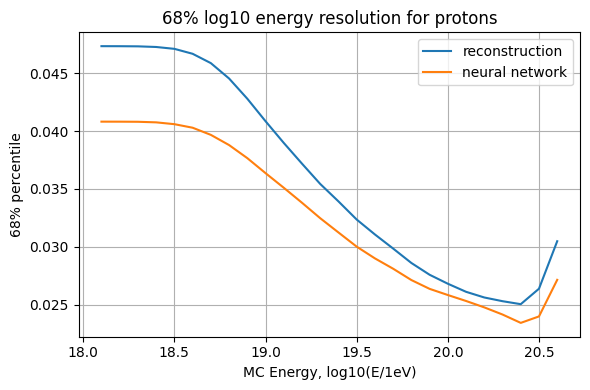

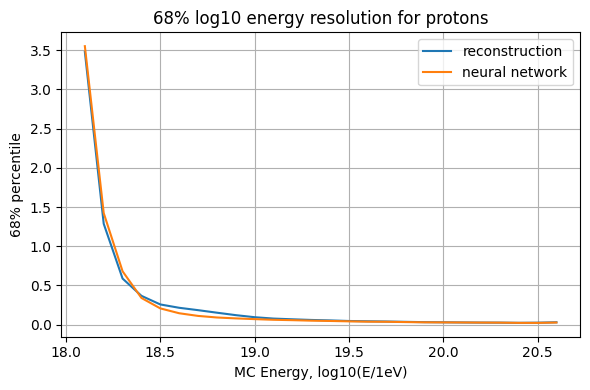

In [ ]:
plot_resolutoin(preds[:,0], h5f, mode='integral')
plot_resolutoin(preds[:,0], h5f, mode='differential', stepE=0.1)